<a href="https://colab.research.google.com/github/JanMarcelKezmann/Boston-House-Prices/blob/master/Starter_Kernel_for_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import glob
import shutil
import pydicom

import numpy as np
import pandas as pd

from PIL import Image
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
plt.style.use("seaborn-white")
from matplotlib import cm
%matplotlib inline
import seaborn as sns
sns.set_style("white")

# necessary to import rle2mask from mask_functions
import sys
sys.path.insert(0, "../input/siim-acr-pneumothorax-segmentation")
from mask_functions import rle2mask

print(os.listdir("../input"))

['siim-acr-pneumothorax-segmentation', 'siimacr-pneumothorax-segmentation-data-256', 'siim-acr-pneumothorax-segmentation-data']


In [0]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from skimage.transform import resize

import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Input, Activation, Concatenate, Cropping2D, UpSampling2D, Conv2D, Conv2DTranspose, MaxPooling2D

K.set_image_data_format("channels_last")

In [0]:
def show_dcm_info(dataset):
    print("Filename...............:", file_path)
    print("Storage type...........:", dataset.SOPClassUID)
    print()
    
    patient_name = dataset.PatientName
    display_name = patient_name.family_name + ", " + patient_name.given_name
    print("Patient's name.........:", display_name)
    print("Patient ID.............:", dataset.PatientID)
    print("Patient's Age..........:", dataset.PatientAge)
    print("Patient's Sex..........:", dataset.PatientSex)
    print("Modality...............:", dataset.Modality)
    print("Body Part Examined.....:", dataset.BodyPartExamined)
    print("View Position..........:", dataset.ViewPosition)
    
    if "PixelData" in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.............: {rows:d} x {cols:d}, {size:d} bytes".format(rows=rows, cols=cols, size=len(dataset.PixelData)))
        
        if "PixelSpacing" in dataset:
            print("Pixel Spacing..........", dataset.PixelSpacing)
            
def plot_pixel_array(dataset, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()

Filename...............: ../input/siim-acr-pneumothorax-segmentation/sample images/1.2.276.0.7230010.3.1.4.8323329.10003.1517875220.942420.dcm
Storage type...........: 1.2.840.10008.5.1.4.1.1.7

Patient's name.........: cf71a760-f693-4ccf-acd4-a41ff4845a5f, 
Patient ID.............: cf71a760-f693-4ccf-acd4-a41ff4845a5f
Patient's Age..........: 65
Patient's Sex..........: M
Modality...............: CR
Body Part Examined.....: CHEST
View Position..........: AP
Image size.............: 1024 x 1024, 111914 bytes
Pixel Spacing.......... ['0.168', '0.168']


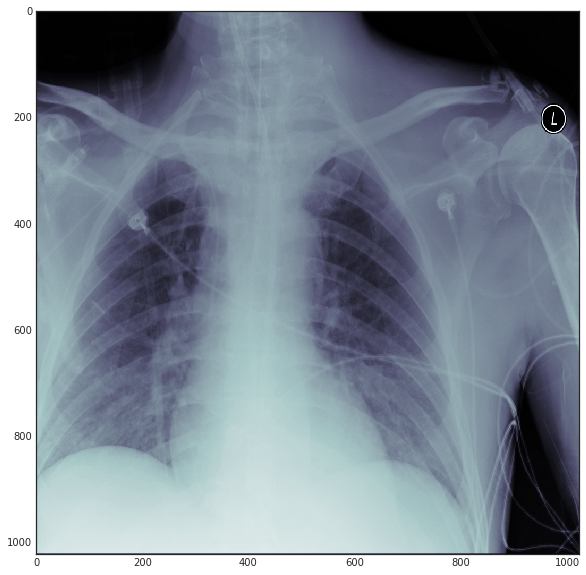

In [0]:
for file_path in glob.glob("../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm"):
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    plot_pixel_array(dataset)
    break

# Visualizing The Masks

In [0]:
# num_img = len(glob.glob("../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm"))
# fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img * 10, 10))
# for q, file_path in enumerate(glob.glob("../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm")):
#     dataset = pydicom.dcmread(file_path)
#     # show_dcm_info(dataset)
    
#     ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)

In [0]:
# # Define Starting index of images and total number of images to show
# start = 5
# num_img = 4

# fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img * 10, 10))
# for q, file_path in enumerate(glob.glob("../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm")[start:start + num_img]):
#     dataset = pydicom.dcmread(file_path)
#     # show_dcm_info(dataset)
    
#     ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)

In [0]:
# df = pd.read_csv("../input/siim-acr-pneumothorax-segmentation/sample images/train-rle-sample.csv", header=None, index_col=0)
# fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img * 10, 10))
# for q, file_path in enumerate(glob.glob("../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm")[start:start + num_img]):
#     dataset = pydicom.dcmread(file_path)
    
#     # getting the image id (number)
# #     print(file_path.split("/")[-1][:-4])
    
#     ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
#     if df.loc[file_path.split("/")[-1][:-4], 1] != "-1":
#         mask = rle2mask(df.loc[file_path.split("/")[-1][:-4], 1], 1024, 1024).T
#         ax[q].set_title("See Marker")
#         ax[q].imshow(mask, alpha=0.3, cmap="Reds")
#     else:
#         ax[q].set_title("Nothing to See")

# Vanilla Unet

### Load the full dataset

In [0]:
# train_glob = "../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-train/*/*/*.dcm"
# test_glob = "../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom_images-test/*/*/*.dcm"

# train_fns = sorted(glob.glob(train_glob))[:5000]
# test_fns = sorted(glob.glob(test_glob))[:5000]

# df_full = pd.read_csv("../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/train-rle.csv", index_col="ImageId")
# df_full.columns

In [0]:
# img_height, img_width = 1024, 1024
# img_channels = 1

# # get train images and masks
# X_train = np.zeros((len(train_fns), img_height, img_width, img_channels), dtype=np.uint8)
# y_train = np.zeros((len(train_fns), img_height, img_width, 1), dtype=np.bool)
# print("Getting train images and masks ...")

# sys.stdout.flush()
# counter = 1
# for n, _id in tqdm_notebook(enumerate(train_fns), total=len(train_fns)):
#     dataset = pydicom.read_file(_id)
#     X_train[n] = np.expand_dims(dataset.pixel_array, axis=2)
#     try:
#         if '-1' in df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
#             y_train[n] = np.zeros((1024, 1024, 1))
#         else:
#             if type(df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']) == str:
#                 y_train[n] = np.expand_dims(rle2mask(df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels'], 1024, 1024), axis=2)
#             else:
#                 y_train[n] = np.zeros((1024, 1024, 1))
#                 for x in df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
#                     y_train[n] =  y_train[n] + np.expand_dims(rle2mask(x, 1024, 1024), axis=2)
#     except KeyError:
#         counter += 1
# #         print(f"Key {_id.split('/')[-1][:-4]} without mask, assuming healthy patient.")
#         # Assuming masks are empty
#         y_train[n] = np.zeros((1024, 1024, 1))
        
# print(counter)

# other model

==============================================================================================================================================

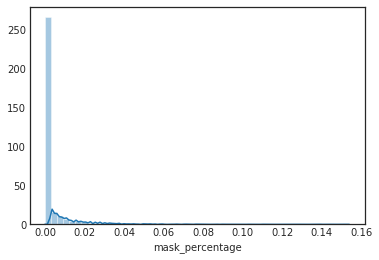

In [0]:
all_mask_fn = glob.glob("../input/siimacr-pneumothorax-segmentation-data-256/masks/*")
mask_df = pd.DataFrame()
mask_df["file_names"] = all_mask_fn
mask_df["mask_percentage"] = 0
mask_df.set_index("file_names", inplace=True)

for fn in all_mask_fn:
    mask_df.loc[fn, "mask_percentage"] = np.array(Image.open(fn)).sum() / (256 * 256 * 255) #255 is bcz img range is 255
    
mask_df.reset_index(inplace=True)
sns.distplot(mask_df.mask_percentage)
mask_df["lables"] = 0
mask_df.loc[mask_df.mask_percentage > 0, "labels"] = 1

In [0]:
all_train_fn = glob.glob("../input/siimacr-pneumothorax-segmentation-data-256/train/*")
total_samples = len(all_train_fn)
idx = np.arange(total_samples)
mask_df.labels = mask_df.labels.fillna(0)

train_fn = all_train_fn[:10000]
val_fn = all_train_fn[10000:]
# check if next split is necessary
masks_train_fn = all_mask_fn[:10000]
masks_val_fn = all_mask_fn[10000:]

print("No. of train files:", len(train_fn))
print("No. of test files:", len(val_fn))
print("No. of mask train files:", len(masks_train_fn))
print("No. of mask test files:", len(masks_val_fn))

No. of train files: 10000
No. of test files: 675
No. of mask train files: 10000
No. of mask test files: 675


In [0]:
print(len(all_mask_fn))
print(all_mask_fn[0])
print(len(all_train_fn))
print(all_train_fn[0])
print()
print()
print(train_fn[0])
print()
print(masks_train_fn[0])
print()
print(val_fn[0])
print()
print(masks_val_fn[0])

10675
../input/siimacr-pneumothorax-segmentation-data-256/masks/1.2.276.0.7230010.3.1.4.8323329.14213.1517875250.265210.png
10675
../input/siimacr-pneumothorax-segmentation-data-256/train/1.2.276.0.7230010.3.1.4.8323329.14213.1517875250.265210.png


../input/siimacr-pneumothorax-segmentation-data-256/train/1.2.276.0.7230010.3.1.4.8323329.14213.1517875250.265210.png

../input/siimacr-pneumothorax-segmentation-data-256/masks/1.2.276.0.7230010.3.1.4.8323329.14213.1517875250.265210.png

../input/siimacr-pneumothorax-segmentation-data-256/train/1.2.276.0.7230010.3.1.4.8323329.12278.1517875238.352109.png

../input/siimacr-pneumothorax-segmentation-data-256/masks/1.2.276.0.7230010.3.1.4.8323329.12278.1517875238.352109.png


In [0]:
height, width, batch_size = 256, 256, 16

# Generates Data for tf.Keras
class DataGenerator(Sequence):
    def __init__(self, train_im_paths=train_fn, val_im_paths=val_fn,
                 augmentations=None, batch_size=batch_size, img_size=256, n_channels=3, shuffle=True):
#         'Initialization'
        self.batch_size = batch_size
        self.train_im_paths = train_im_paths
        self.val_im_paths = val_im_paths
        self.img_size = img_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augmentations
        self.on_epoch_end()
        
    # Denotes the number of batches per epoch
    def __len__(self):
        if self.augment == AUGMENTATIONS_TEST or self.augment == AUGMENTATIONS_TEST_FLIPPED:
            return int(np.ceil(len(self.val_im_paths) / self.batch_size))
        else:
            return int(np.ceil(len(self.train_im_paths) / self.batch_size))
    
    # Generate one Batch of Data
    def __getitem__(self, index):
        # Generate indices of the batch
        if self.augment == AUGMENTATIONS_TEST or self.augment == AUGMENTATIONS_TEST_FLIPPED:
            indices = self.indices[index * self.batch_size:min((index + 1) * self.batch_size, len(self.val_im_paths))]
            # Find list of IDs
            list_IDs_im = [self.val_im_paths[k] for k in indices]
        else:
            indices = self.indices[index * self.batch_size:min((index + 1) * self.batch_size, len(self.train_im_paths))]
            # Find list of IDs
            list_IDs_im = [self.train_im_paths[k] for k in indices]

        # Generate Data
        X, y = self.data_generation(list_IDs_im)
        if self.augment is None:
            return X, np.array(y) / 255
        else:
            im, mask = [], []
            for X, y in zip(X, y):
                augmented = self.augment(image=X, mask=y)
                im.append(augmented["image"])
                mask.append(augmented["mask"])
            return np.array(im), np.array(mask) / 255
        
    # Updates indices after each epoch
    def on_epoch_end(self):
        if self.augment == AUGMENTATIONS_TEST or self.augment == AUGMENTATIONS_TEST_FLIPPED:
            self.indices = np.arange(len(self.val_im_paths))
        else:
            self.indices = np.arange(len(self.train_im_paths))
        
        if self.shuffle == True:
            np.random.shuffle(self.indices)
        
            
    # Generates data containing batch_size samples
    def data_generation(self, list_IDs_im):
        # Initialization
        X = np.empty((len(list_IDs_im), self.img_size, self.img_size, self.n_channels))
        y = np.empty((len(list_IDs_im), self.img_size, self.img_size, 1))

        # Generate data
        for i, im_path in enumerate(list_IDs_im):
            im = np.array(Image.open(im_path))
            mask_path = im_path.replace("train", "masks")
            mask = np.array(Image.open(mask_path))

            if len(im.shape) == 2:
                im = np.repeat(im[..., None], 3, 2)
            
            # Resize sample
            X[i, ] = cv2.resize(im, (self.img_size, self.img_size))

            # Store Class
            y[i, ] = cv2.resize(mask, (self.img_size, self.img_size))[..., np.newaxis]
            y[y > 0] = 255

        return np.uint8(X), np.uint8(y)

In [0]:
import cv2

from albumentations import (Compose, HorizontalFlip, CLAHE, HueSaturationValue, RandomBrightness,
                            RandomContrast, RandomGamma, OneOf, ToFloat, ShiftScaleRotate, GridDistortion,
                            ElasticTransform, JpegCompression, HueSaturationValue, RGBShift,
                            RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,
                            CenterCrop, IAAAdditiveGaussianNoise, GaussNoise, OpticalDistortion, RandomSizedCrop)

AUGMENTATIONS_TRAIN = Compose([HorizontalFlip(p=0.5),
                              OneOf([RandomContrast(), RandomGamma(), RandomBrightness(),], p=0.3),
                              RandomSizedCrop(min_max_height=(128, 256), height=height, width=width, p=0.5),
                              ToFloat(max_value=1)], p=1)

AUGMENTATIONS_TEST = Compose([ToFloat(max_value=1)], p=1)

AUGMENTATIONS_TEST_FLIPPED = Compose([HorizontalFlip(), ToFloat(max_value=1)], p=1)

## Train Set Images with Masks

Text(0.5, 0.98, 'Chest X-Rays, Red: Pneumothorax.')

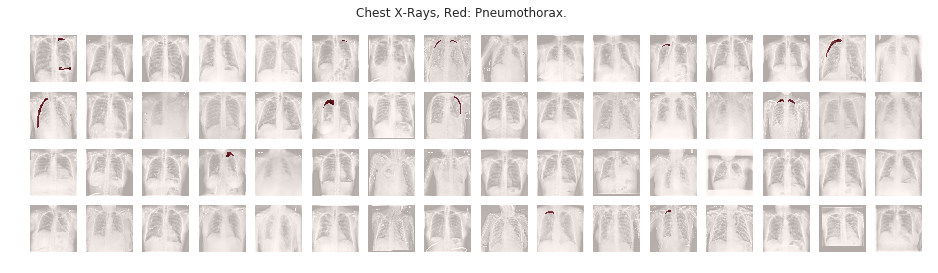

In [0]:
a = DataGenerator(batch_size=64, shuffle=False)
images, masks = a.__getitem__(0)

max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axis = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i, (img, mask) in enumerate(zip(images, masks)):
    ax = axis[int(i / grid_width), i % grid_width]
    ax.imshow(img.squeeze(), cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.7, cmap="Reds")
    ax.axis("off")
    
plt.suptitle("Chest X-Rays, Red: Pneumothorax.")

## Images after Augmentations

Text(0.5, 0.98, 'Chest X-Rays, Red: Pneumothorax.')

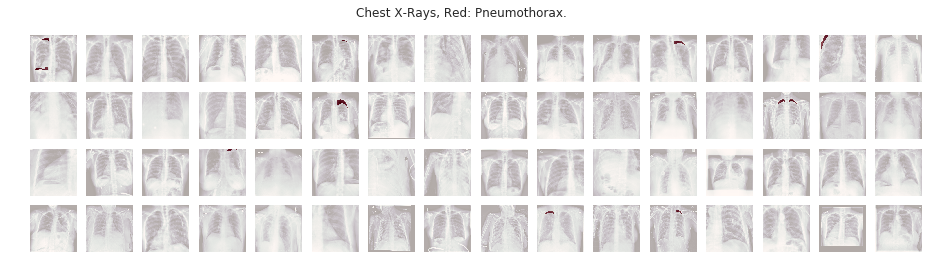

In [0]:
a = DataGenerator(batch_size=64, augmentations=AUGMENTATIONS_TRAIN, shuffle=False)
images, masks = a.__getitem__(0)

max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axis = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i, (img, mask) in enumerate(zip(images, masks)):
    ax = axis[int(i / grid_width), i % grid_width]
    ax.imshow(img[:,:,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.7, cmap="Reds")
    ax.axis("off")
    
plt.suptitle("Chest X-Rays, Red: Pneumothorax.")

Text(0.5, 0.98, 'Chest X-Rays, Red: Pneumothorax.')

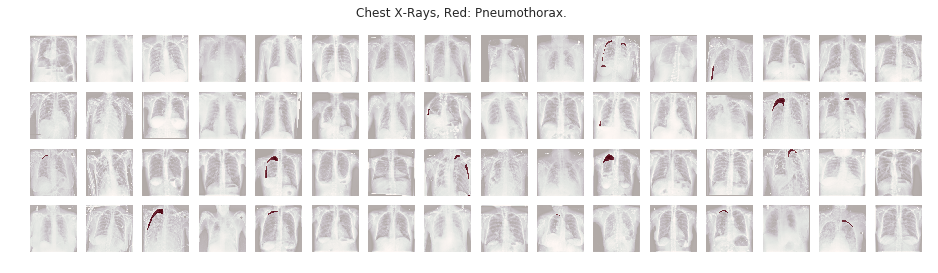

In [0]:
a = DataGenerator(batch_size=64, augmentations=AUGMENTATIONS_TEST, shuffle=False)
images, masks = a.__getitem__(0)

max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axis = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i, (img, mask) in enumerate(zip(images, masks)):
    ax = axis[int(i / grid_width), i % grid_width]
    ax.imshow(img[:,:,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.7, cmap="Reds")
    ax.axis("off")
    
plt.suptitle("Chest X-Rays, Red: Pneumothorax.")

# Calculation IOU

In [0]:
# Thanks to https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow

# Numpy Version
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = 0.0
    
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal wit empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # Non empty mask case
        # Union is never empty hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metric is a stepwise approximation ofthe real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45) * 20)) / 10
        
        metric += iou
        
    # take the average over all images in batch
    metric /= batch_size
    return metric

# Tensorflow Version
def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

# Defining Dice Loss

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, "float32")
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), "float32")
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + K.log(1. - dice_loss(y_true, y_pred))

# Define Learning Rate Scheduler

In [0]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr
        
    def get_callbacks(self, model_prefix="Model"):
        callback_list = [callbacks.ModelCheckpoint("./keras.model", monitor="val_loss", mode="min", save_best_only=True, verbose=1),
                        swa,
                        callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)]
        return callback_list
    
    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M)) # t-1 is used when t hast 1-based indexing
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

In [0]:
def u_net(input_shape=(128, 128, 1)):
    X_input = Input(input_shape)
    
    X1 = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same", name="conv1_0", kernel_initializer=glorot_uniform(seed=0))(X_input)
    X1 = Activation("relu")(X1)
    X1 = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same", name="conv1_1", kernel_initializer=glorot_uniform(seed=0))(X1)
    X1 = Activation("relu")(X1)
    P1 = MaxPooling2D((2, 2), strides=(2, 2), padding="same", name="pool1")(X1)
    
    X2 = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding="same", name="conv2_0", kernel_initializer=glorot_uniform(seed=0))(P1)
    X2 = Activation("relu")(X2)
    X2 = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding="same", name="conv2_1", kernel_initializer=glorot_uniform(seed=0))(X2)
    X2 = Activation("relu")(X2)
    P2 = MaxPooling2D((2, 2), strides=(2, 2), padding="same", name="pool2")(X2)
    
    X3 = Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding="same", name="conv3_0", kernel_initializer=glorot_uniform(seed=0))(P2)
    X3 = Activation("relu")(X3)
    X3 = Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding="same", name="conv3_1", kernel_initializer=glorot_uniform(seed=0))(X3)
    X3 = Activation("relu")(X3)
    P3 = MaxPooling2D((2, 2), strides=(2, 2), padding="same", name="pool3")(X3)
    
    X4 = Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding="same", name="conv4_0", kernel_initializer=glorot_uniform(seed=0))(P3)
    X4 = Activation("relu")(X4)
    X4 = Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding="same", name="conv4_1", kernel_initializer=glorot_uniform(seed=0))(X4)
    X4 = Activation("relu")(X4)
    P4 = MaxPooling2D((2, 2), strides=(2, 2), padding="same", name="pool4")(X4)
    
    X5 = Conv2D(1024, kernel_size=(3, 3), strides=(1, 1), padding="same", name="conv5_0", kernel_initializer=glorot_uniform(seed=0))(P4)
    X5 = Activation("relu")(X5)
    X5 = Conv2D(1024, kernel_size=(3, 3), strides=(1, 1), padding="same", name="conv5_1", kernel_initializer=glorot_uniform(seed=0))(X5)
    X5 = Activation("relu")(X5)
    
    X6 = UpSampling2D((2, 2))(X5)
    X6 = Concatenate()([X6, X4])
    X6 = Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding="same", name="conv6_0", kernel_initializer=glorot_uniform(seed=0))(X6)
    X6 = Activation("relu")(X6)
    X6 = Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding="same", name="conv6_1", kernel_initializer=glorot_uniform(seed=0))(X6)
    X6 = Activation("relu")(X6)
    
    X7 = UpSampling2D((2, 2))(X6)
    X7 = Concatenate()([X7, X3])
    X7 = Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding="same", name="conv7_0", kernel_initializer=glorot_uniform(seed=0))(X7)
    X7 = Activation("relu")(X7)
    X7 = Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding="same", name="conv7_1", kernel_initializer=glorot_uniform(seed=0))(X7)
    X7 = Activation("relu")(X7)
    
    X8 = UpSampling2D((2, 2))(X7)
    X8 = Concatenate()([X8, X2])
    X8 = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding="same", name="conv8_0", kernel_initializer=glorot_uniform(seed=0))(X8)
    X8 = Activation("relu")(X8)
    X8 = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding="same", name="conv8_1", kernel_initializer=glorot_uniform(seed=0))(X8)
    X8 = Activation("relu")(X8)
    
    X9 = UpSampling2D((2, 2))(X8)
    X9 = Concatenate()([X9, X1])
    X9 = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same", name="conv9_0", kernel_initializer=glorot_uniform(seed=0))(X9)
    X9 = Activation("relu")(X9)
    X9 = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same", name="conv9_1", kernel_initializer=glorot_uniform(seed=0))(X9)
    X9 = Activation("relu")(X9)
    
    # Final 1x1 Convolution followed by Sigmoid Activation
    X10 = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding="same", name="conv10_0", kernel_initializer=glorot_uniform(seed=0))(X9)
    X_output = Activation("sigmoid")(X10)
    
    # initialize Model
    model = Model(X_input, X_output)
    return model

In [0]:
K.clear_session()
img_size = 256
model = u_net(input_shape=(img_size, img_size, 3))

# Stochastic Weight Averaging

In [0]:
class SWA(tf.keras.callbacks.Callback):
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch
        
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params["epochs"]
        print("Stochastic weight averaging selected for last {} epochs".format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
        elif epoch > self.swa_epoch:
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * (epoch - self.swa_epoch) + self.model.get_weights()[i]) / ((epoch - self.swa_epoch) + 1)
        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print("Final model parameters set to stochastic weight average.")
        self.model.save_weights(self.filepath)
        print("Final stochastic averaged weights saved to file.")

In [0]:
model.compile(loss=bce_dice_loss, optimizer="adam", metrics=[my_iou_metric])

In [0]:
# model.summary()

In [0]:
import tensorflow.keras.callbacks as callbacks
epochs = 5
snapshot = SnapshotCallbackBuilder(nb_epochs=epochs, nb_snapshots=1, init_lr=1e-3)
batch_size = 16
img_size = 256
swa = SWA('./keras_swa.model', 1)

# Generators
training_generator = DataGenerator(augmentations=AUGMENTATIONS_TRAIN, img_size=img_size)
validation_generator = DataGenerator(augmentations=AUGMENTATIONS_TEST, img_size=img_size)

In [0]:
history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,                            
                              use_multiprocessing=False,
                              epochs=epochs,
                              verbose=1,
                              callbacks=snapshot.get_callbacks())

Stochastic weight averaging selected for last 4 epochs


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in greater


Epoch 1/5


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in greater


624/625 [============================>.] - ETA: 0s - loss: 1.2277 - my_iou_metric: 0.6028
Epoch 00001: val_loss improved from inf to 1.01522, saving model to ./keras.model
625/625 [==============================] - 276s 441ms/step - loss: 1.2274 - my_iou_metric: 0.6030 - val_loss: 1.0152 - val_my_iou_metric: 0.3275
Epoch 2/5
624/625 [============================>.] - ETA: 0s - loss: 1.0273 - my_iou_metric: 0.6942
Epoch 00002: val_loss improved from 1.01522 to 0.97849, saving model to ./keras.model
625/625 [==============================] - 267s 427ms/step - loss: 1.0272 - my_iou_metric: 0.6935 - val_loss: 0.9785 - val_my_iou_metric: 0.2166
Epoch 3/5
624/625 [============================>.] - ETA: 0s - loss: 0.9823 - my_iou_metric: 0.1785
Epoch 00003: val_loss improved from 0.97849 to 0.94284, saving model to ./keras.model
625/625 [==============================] - 268s 428ms/step - loss: 0.9823 - my_iou_metric: 0.1787 - val_loss: 0.9428 - val_my_iou_metric: 0.1919
Epoch 4/5
624/625 [==

79

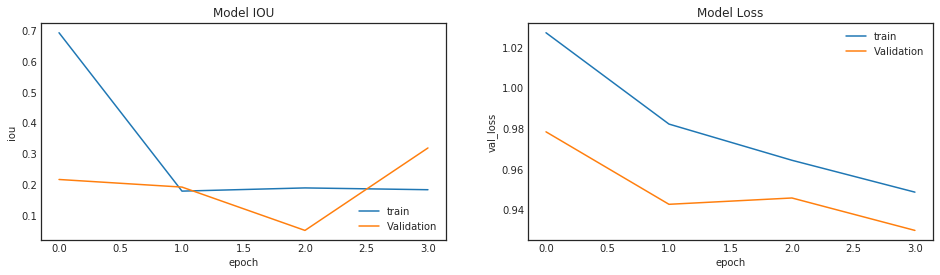

In [0]:
import gc
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["my_iou_metric"][1:])
plt.plot(history.history["val_my_iou_metric"][1:])
plt.ylabel("iou")
plt.xlabel("epoch")
plt.legend(["train", "Validation"], loc="lower right")
plt.title("Model IOU")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"][1:])
plt.plot(history.history["val_loss"][1:])
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.legend(["train", "Validation"], loc="upper right")
plt.title("Model Loss")
gc.collect()

In [0]:
# Load best model or swa model if not available
try:
    print("Using SWA Weight Model")
    model.load_weights("./keras_swa.model")
except Exception as e:
    print(e)
    model.load_weights("./keras.model")

Using SWA Weight Model


# Predict the validation set to do a sanity check

In [0]:
def predict_result(model, validation_generator, img_size):
    predictions_test1 = model.predict_generator(validation_generator).reshape(-1, img_size, img_size)
    return predictions_test1

In [0]:
validation_generator = DataGenerator(augmentations=AUGMENTATIONS_TEST, img_size=img_size, shuffle=False)
validation_predictions = predict_result(model, validation_generator, img_size)

# AUGMENTATIONS_TEST_FLIPPED = Compose([
#     HorizontalFlip(),
#     ToFloat(max_value=1)
# ],p=1)

# validation_generator_flipped = DataGenerator(train_im_path = valid_im_path ,
#                                      train_mask_path=valid_mask_path,augmentations=AUGMENTATIONS_TEST_FLIPPED,
#                                      img_size=img_size,shuffle=False)

# preds_valid_orig = predict_result(model,validation_generator,img_size)
# flipped_validation_predictions = predict_result(model,validation_generator_flipped,img_size)
# flipped_validation_predictions = np.array([np.fliplr(x) for x in flipped_validation_predictions])

# validation_predictions = 0.5 * original_validation_predictions + 0.5 * flipped_validation_predictions

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in greater


In [0]:
y_valid_original = np.array([cv2.resize(np.array(Image.open(fn)), (img_size, img_size)) for fn in val_fn])
assert y_valid_original.shape == validation_predictions.shape

# Plot some predictions for validation images

Text(0.5, 0.98, 'Green: Prediction, Red: Pneumothorax.')

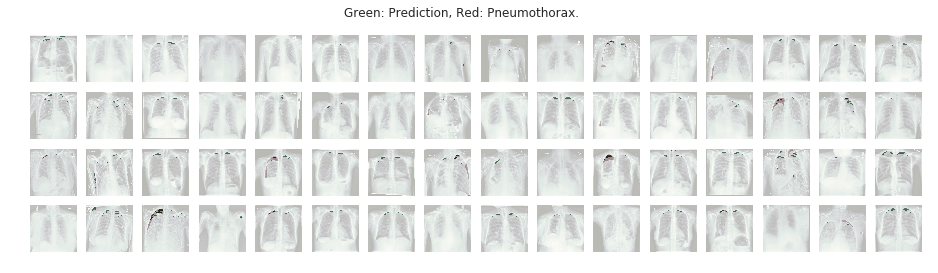

In [0]:
threshold_best = 0.5
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axis = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

validation_generator = DataGenerator(augmentations=AUGMENTATIONS_TEST,
                                     img_size=img_size ,batch_size=64, shuffle=False)

images,masks = validation_generator.__getitem__(0)
for i, (im, mask) in enumerate(zip(images, masks)):
    pred = validation_predictions[i]
    ax = axis[int(i / grid_width), i % grid_width]
    ax.imshow(im[..., 0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Greens")
    ax.axis("off")
plt.suptitle("Green: Prediction, Red: Pneumothorax.")

In [0]:
# Thanks to https://www.kaggle.com/aglotero/another-iou-metric

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:, 1:]
    union = union[1:, 1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

original_y_validation = np.array([cv2.resize(np.array(Image.open(fn)), (img_size,img_size)) for fn in masks_val_fn])
assert original_y_validation.shape == validation_predictions.shape

In [0]:
## Scoring for last model
thresholds = np.linspace(0.2, 0.9, 31)
ious = np.array([iou_metric_batch(original_y_validation, np.int32(validation_predictions > threshold)) for threshold in tqdm_notebook(thresholds)])

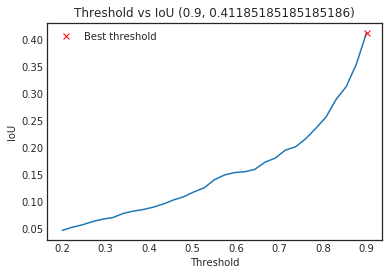

In [0]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

Text(0.5, 0.98, 'Green:Prediction , Red: Pneumothorax.')

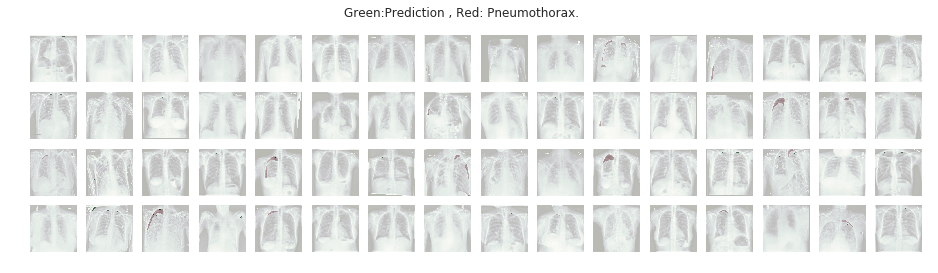

In [0]:
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

validation_generator = DataGenerator(augmentations=AUGMENTATIONS_TEST,
                                     img_size=img_size, batch_size=64, shuffle=False)

images,masks = validation_generator.__getitem__(0)
for i,(im, mask) in enumerate(zip(images, masks)):
    pred = validation_predictions[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[...,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Greens")
    ax.axis("off")
plt.suptitle("Green:Prediction , Red: Pneumothorax.")

# Test Set Prediction

In [0]:
test_fn = glob.glob("../input/siimacr-pneumothorax-segmentation-data-256/test/*")

x_test = [cv2.resize(np.array(Image.open(fn)), (img_size,img_size)) for fn in test_fn]
x_test = np.array(x_test)
x_test = np.array([np.repeat(im[...,None],3,2) for im in x_test])
print(x_test.shape)
original_test_predictions = model.predict(x_test, batch_size=batch_size)

x_test = np.array([np.fliplr(x) for x in x_test])
test_predictions_flipped = model.predict(x_test, batch_size=batch_size)
test_predictions_flipped = np.array([np.fliplr(x) for x in test_predictions_flipped])

test_predictions = 0.5 * original_test_predictions + 0.5 * test_predictions_flipped

(1377, 256, 256, 3)


# Some Test Set Predictions

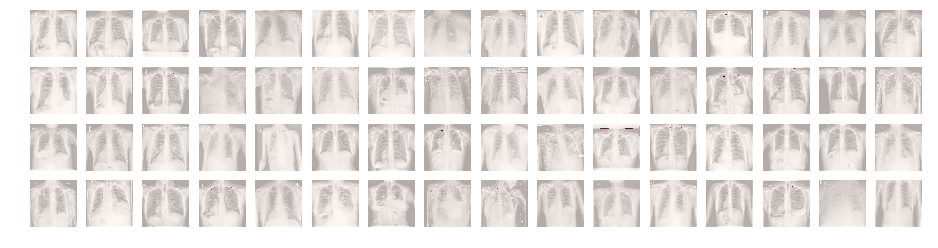

In [0]:
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axis = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i, idx in enumerate(test_fn[:max_images]):
    img = x_test[i]
    pred = test_predictions[i].squeeze()
    ax = axis[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.7, cmap="Reds")
    ax.axis("off")

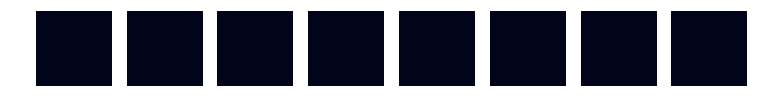

In [0]:
import sys
sys.path.insert(0, "../input/siim-acr-pneumothorax-segmentation")

from mask_functions import rle2mask, mask2rle
import pdb

# Generate rle encodings (images are first converted to the original size)
rles = []
i, max_img = 1,10
plt.figure(figsize=(16,4))
for p in tqdm_notebook(test_predictions):
    p = p.squeeze()
    im = cv2.resize(p,(1024,1024))
    im = im > threshold_best
#     zero out the smaller regions.
    if im.sum() < 1024 * 2:
        im[:] = 0
    im = (im.T * 255).astype(np.uint8)  
    rles.append(mask2rle(im, 1024, 1024))
    i += 1
    if i < max_img:
        plt.subplot(1, max_img, i)
        plt.imshow(im)
        plt.axis("off")

In [0]:
ids = [o.split("/")[-1][:-4] for o in test_fn]
sub_df = pd.DataFrame({"ImageId": ids, "EncodedPixels": rles})
sub_df.loc[sub_df.EncodedPixels=="", "EncodedPixels"] = '-1'
sub_df.tail(60)

,ImageId,EncodedPixels
1317,1.2.276.0.7230010.3.1.4.8323329.6421.151787519...,-1
1318,1.2.276.0.7230010.3.1.4.8323329.6920.151787520...,-1
1319,1.2.276.0.7230010.3.1.4.8323329.6749.151787519...,-1
1320,1.2.276.0.7230010.3.1.4.8323329.6911.151787520...,-1
1321,1.2.276.0.7230010.3.1.4.8323329.6418.151787519...,-1
1322,1.2.276.0.7230010.3.1.4.8323329.6271.151787519...,-1
1323,1.2.276.0.7230010.3.1.4.8323329.6157.151787519...,-1
1324,1.2.276.0.7230010.3.1.4.8323329.6538.151787519...,-1
1325,1.2.276.0.7230010.3.1.4.8323329.5901.151787519...,-1
1326,1.2.276.0.7230010.3.1.4.8323329.6638.151787519...,-1


In [0]:
sub_df.to_csv("submission4.csv", index=False)

In [0]:
sub_df.tail(15)

,ImageId,EncodedPixels
1362,1.2.276.0.7230010.3.1.4.8323329.5810.151787519...,-1
1363,1.2.276.0.7230010.3.1.4.8323329.6500.151787519...,-1
1364,1.2.276.0.7230010.3.1.4.8323329.6857.151787520...,-1
1365,1.2.276.0.7230010.3.1.4.8323329.6193.151787519...,-1
1366,1.2.276.0.7230010.3.1.4.8323329.6607.151787519...,-1
1367,1.2.276.0.7230010.3.1.4.8323329.6202.151787519...,-1
1368,1.2.276.0.7230010.3.1.4.8323329.6114.151787519...,-1
1369,1.2.276.0.7230010.3.1.4.8323329.6900.151787520...,-1
1370,1.2.276.0.7230010.3.1.4.8323329.6765.151787520...,-1
1371,1.2.276.0.7230010.3.1.4.8323329.6227.151787519...,-1
